In [3]:
# Cell 1 — imports and setup
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)
sns.set_style("whitegrid")

sys.path.append(os.path.abspath(".."))  # ensure src is importable

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [4]:
# Cell 2 — load clean split and try to load a saved poisoned dataset (fallback to attack)
from src.data_utils import load_housing, get_split
from src.attacks import label_flip, outlier_injection

X, y = load_housing()
X_train, X_test, y_train, y_test = get_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print("Clean train shape:", X_train.shape, y_train.shape, "Test shape:", X_test.shape, y_test.shape)

# prefer saved poisoned file if exists
poisoned_path = "../data/poisoned/label_flip_frac10.csv"
if os.path.exists(poisoned_path):
    print("Loading poisoned dataset from", poisoned_path)
    df = pd.read_csv(poisoned_path)
    # assume last column is target (named 'target' if saved by earlier notebook)
    if 'target' in df.columns:
        y_p = df['target']
        X_p = df.drop(columns=['target'])
    else:
        # fallback: last column
        y_p = df.iloc[:, -1]
        X_p = df.iloc[:, :-1]
else:
    print("Poisoned file not found — generating label_flip fraction=0.1")
    X_p, y_p = label_flip(X_train, y_train, fraction=0.1, bias=10.0, random_state=RANDOM_STATE)

print("Poisoned train shape:", X_p.shape, y_p.shape)

Clean train shape: (16512, 8) (16512,) Test shape: (4128, 8) (4128,)
Loading poisoned dataset from ../data/poisoned/label_flip_frac10.csv
Poisoned train shape: (16512, 8) (16512,)


In [5]:
# Cell 3 — import defenses and model functions
from src.defenses import zscore_filter, iqr_filter, isolation_forest_filter, ransac_regression
from src.models import train_model, evaluate

In [6]:
# Cell 4 — helper function
def apply_defense_and_eval(defense_name, X_train_poisoned, y_train_poisoned):
    if defense_name == "none":
        Xd, yd = X_train_poisoned.copy(), y_train_poisoned.copy()
    elif defense_name == "zscore":
        Xd, yd = zscore_filter(X_train_poisoned, y_train_poisoned, threshold=3.0)
    elif defense_name == "iqr":
        Xd, yd = iqr_filter(X_train_poisoned, y_train_poisoned)
    elif defense_name == "isolation_forest":
        # try a conservative contamination value; tune later if needed
        Xd, yd = isolation_forest_filter(X_train_poisoned, y_train_poisoned, contamination=0.05)
    elif defense_name == "ransac":
        # RANSAC returns a trained model; we will evaluate it directly
        model = ransac_regression(X_train_poisoned, y_train_poisoned)
        metrics = evaluate(model, X_test, y_test)
        return {
            "defense": "ransac",
            "n_before": len(X_train_poisoned),
            "n_after": len(X_train_poisoned),  # RANSAC does not drop rows; it weights inliers internally
            "rmse": metrics["rmse"],
            "r2": metrics["r2"]
        }
    else:
        raise ValueError("Unknown defense")

    n_before = len(X_train_poisoned)
    n_after = len(Xd)
    # if no samples left after defense, return None
    if n_after == 0:
        return {
            "defense": defense_name,
            "n_before": n_before,
            "n_after": n_after,
            "rmse": float("nan"),
            "r2": float("nan"),
            "note": "no samples left after defense"
        }

    # train normal linear model on defended set
    model = train_model("linear", Xd, yd)
    metrics = evaluate(model, X_test, y_test)
    return {
        "defense": defense_name,
        "n_before": n_before,
        "n_after": n_after,
        "rmse": metrics["rmse"],
        "r2": metrics["r2"]
    }

In [7]:
# Cell 5 — run defenses
defense_list = ["none", "zscore", "iqr", "isolation_forest", "ransac"]
results = []
for d in defense_list:
    res = apply_defense_and_eval(d, X_p, y_p)
    results.append(res)
    print(res)

df_results = pd.DataFrame(results)
df_results

{'defense': 'none', 'n_before': 16512, 'n_after': 16512, 'rmse': 1.2447056833247716, 'r2': -0.18229672096780414}
{'defense': 'zscore', 'n_before': 16512, 'n_after': 16117, 'rmse': 1.078655051543182, 'r2': 0.11211176087826469}
{'defense': 'iqr', 'n_before': 16512, 'n_after': 14861, 'rmse': 0.745638136065972, 'r2': 0.5757231221795485}
{'defense': 'isolation_forest', 'n_before': 16512, 'n_after': 15686, 'rmse': 1.5241893983950803, 'r2': -0.7728460051445698}
{'defense': 'ransac', 'n_before': 16512, 'n_after': 16512, 'rmse': 0.8748705301968057, 'r2': 0.4159087297812052}


,defense,n_before,n_after,rmse,r2
0,none,16512,16512,1.244706,-0.182297
1,zscore,16512,16117,1.078655,0.112112
2,iqr,16512,14861,0.745638,0.575723
3,isolation_forest,16512,15686,1.524189,-0.772846
4,ransac,16512,16512,0.874871,0.415909


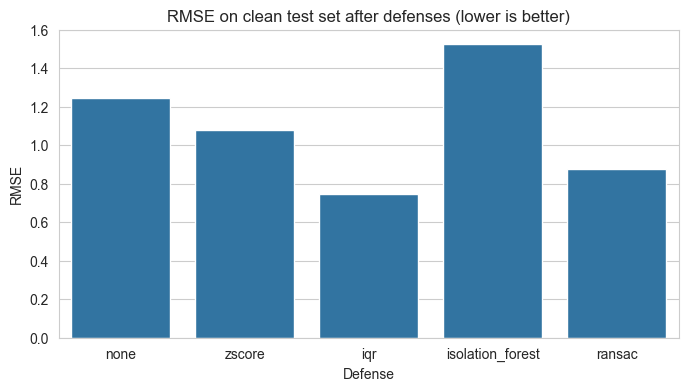

In [8]:
# Cell 6 — plot RMSE comparison
plot_df = df_results.copy()
plot_df = plot_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['rmse'])
plt.figure(figsize=(8,4))
sns.barplot(x="defense", y="rmse", data=plot_df)
plt.title("RMSE on clean test set after defenses (lower is better)")
plt.ylabel("RMSE")
plt.xlabel("Defense")
plt.show()

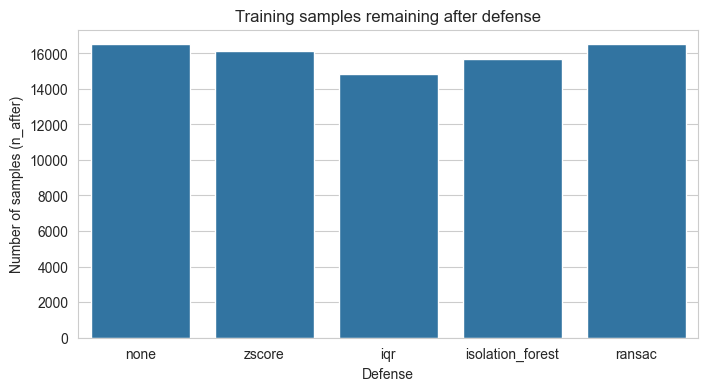

,defense,n_before,n_after,rmse,r2
0,none,16512,16512,1.244706,-0.182297
1,zscore,16512,16117,1.078655,0.112112
2,iqr,16512,14861,0.745638,0.575723
3,isolation_forest,16512,15686,1.524189,-0.772846
4,ransac,16512,16512,0.874871,0.415909


In [9]:
# Cell 7 — sample counts before/after
plt.figure(figsize=(8,4))
sns.barplot(x="defense", y="n_after", data=df_results)
plt.title("Training samples remaining after defense")
plt.ylabel("Number of samples (n_after)")
plt.xlabel("Defense")
plt.show()

display(df_results)

In [10]:
# Cell 8 — save results to results/defenses_summary.csv
os.makedirs("../results", exist_ok=True)
df_results.to_csv("../results/defenses_summary.csv", index=False)
print("Saved ../results/defenses_summary.csv")

Saved ../results/defenses_summary.csv
